# Importing necessary libraries

In [1]:
# !unzip 'data.zip'

In [2]:
import numpy as np 
import pandas as pd 
import os
import pickle

import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from scipy import linalg
from torchvision import transforms, models

%matplotlib inline
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision import models
from scipy.stats import entropy
# from torchmetrics.image.fid import FrechetInceptionDistance

# Directory to save models and losses

In [3]:

os.makedirs('diffusion_losses', exist_ok=True)
os.makedirs('diffusion_models', exist_ok=True)
os.makedirs('dc_gans_losses', exist_ok=True)
os.makedirs('dc_gans_models', exist_ok=True)
os.makedirs('best_models', exist_ok=True)

# Setting a manual seed for reproducibility and other Hyper parameters


In [4]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
dataroot = "Covid19-dataset"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
ngpu = 1

Random Seed:  999


# Data Loading and Set up 

device cuda:0


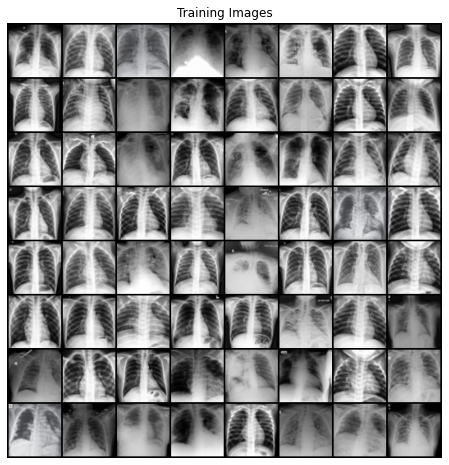

In [5]:

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("device", device)
# Visualization of training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


# Initialize weights

In [6]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define ResidualBlock and UNet

In [7]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.encoder_block(nc, ngf)
        self.enc2 = self.encoder_block(ngf, ngf * 2)
        self.enc3 = self.encoder_block(ngf * 2, ngf * 4)
        self.enc4 = self.encoder_block(ngf * 4, ngf * 8)

        self.res = ResidualBlock(ngf * 8)

        self.dec1 = self.decoder_block(ngf * 8, ngf * 4)
        self.dec2 = self.decoder_block(ngf * 4, ngf * 2)
        self.dec3 = self.decoder_block(ngf * 2, ngf)
        self.dec4 = nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1)

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        r = self.res(e4)

        d1 = self.dec1(r)
        d2 = self.dec2(d1)
        d3 = self.dec3(d2)
        d4 = torch.tanh(self.dec4(d3))

        return d4

# Define DiffusionModel

In [8]:

class DiffusionModel:
    def __init__(self, model, timesteps=1000):
        self.model = model.to(device)
        self.timesteps = timesteps
        self.betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), self.alpha_cumprod[:-1]])
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t):
        noise = torch.randn_like(x_start)
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha_cumprod_t * x_start + sqrt_one_minus_alpha_cumprod_t * noise

    def p_sample(self, x_t, t):
        noise = torch.randn_like(x_t)
        return self.model(x_t) + noise * self.betas[t]

    def sample(self, x_start):
        x_t = x_start
        for t in reversed(range(self.timesteps)):
            x_t = self.p_sample(x_t, t)
        return x_t

# Define PerceptualLoss

In [9]:

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features
        self.layers = nn.Sequential(*list(vgg.children())[:16]).eval()
        for param in self.layers.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_features = self.layers(x)
        y_features = self.layers(y)
        loss = nn.functional.mse_loss(x_features, y_features)
        return loss

# Diffusion model training function

In [10]:
def train_diffusion_model_with_time(dataloader, model, diffusion_model, num_epochs, lr, beta1):
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
    mse_criterion = nn.MSELoss()
    perceptual_criterion = PerceptualLoss().to(device)
    
    # Track time
    start_time = time.time()

    # Lists to keep track of progress
    img_list = []
    G_losses_epoch = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            noise = torch.randn(b_size, nc, image_size, image_size, device=device)
            t = torch.randint(0, diffusion_model.timesteps, (b_size,), device=device)

            x_t = diffusion_model.q_sample(real_cpu, t)
            output = model(x_t)

            mse_loss = mse_criterion(output, real_cpu)
            perceptual_loss = perceptual_criterion(output, real_cpu)
            loss = mse_loss + 0.1 * perceptual_loss

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if i % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] Loss: {loss.item()} MSE Loss: {mse_loss} Perceptual Loss: {perceptual_loss}')
        scheduler.step()

        # Store epoch loss
        G_losses_epoch.append(epoch_loss / len(dataloader))

        # Check how the generator is doing by saving G's output on fixed_noise
        with torch.no_grad():
            fake = model(noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    end_time = time.time()
    training_time = end_time - start_time

    return G_losses_epoch, img_list, training_time


# Calculate FID score

In [11]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from scipy import linalg
import numpy as np
from PIL import Image

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Inception v3 model
inception_model = models.inception_v3(pretrained=True, aux_logits=True).to(device)
inception_model.eval()

# Modify Inception v3 to output features from an intermediate layer
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])
    
    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, start_dim=1)

feature_extractor = FeatureExtractor(inception_model).to(device)

# Helper function to get Inception v3 features
def get_inception_features(images, model, batch_size=32):
    features_list = []
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch = torch.stack([preprocess(img) for img in batch]).to(device)
        with torch.no_grad():
            features = model(batch).detach().cpu().numpy()
        features_list.append(features)
    
    return np.concatenate(features_list, axis=0)

# Calculate mean and covariance of features
def calculate_activation_statistics(features):
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

# Calculate FID score
def calculate_fid(real_images, generated_images, model, eps=1e-6):
    real_features = get_inception_features(real_images, model)
    gen_features = get_inception_features(generated_images, model)
    
    mu_real, sigma_real = calculate_activation_statistics(real_features)
    mu_gen, sigma_gen = calculate_activation_statistics(gen_features)
    
    # Calculate the Frechet distance
    diff = mu_real - mu_gen
    
    # Add small epsilon to the covariance matrices to ensure positive definiteness
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_gen) + np.eye(sigma_real.shape[0]) * eps, disp=False)
    
    # Check if covmean is complex and take the real part if necessary
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_gen - 2*covmean)
    
    # Ensure FID is non-negative
    return max(fid, 0)


/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Calculate Inception Score Function

In [12]:
def calculate_inception_score(images, model, splits=5):
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    processed_images = torch.stack([preprocess(img) for img in images]).to(device)
    with torch.no_grad():
        preds = model(processed_images).detach().cpu().numpy()

    preds = np.exp(preds) / np.sum(np.exp(preds), axis=1, keepdims=True)
    split_scores = []

    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = [entropy(pyx, py) for pyx in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# Function to generate images

In [13]:

def generate_images(model, diffusion_model, num_images):
    with torch.no_grad():
        noise = torch.randn(num_images, nc, image_size, image_size, device=device)
        generated_images = diffusion_model.sample(noise)
        return generated_images


# Function to load losses from pickle files

In [46]:
def load_losses(directory):
    losses = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            with open(os.path.join(directory, filename), 'rb') as f:
                losses.append(pickle.load(f))
                filenames.append(filename)
    return losses, filenames

# Function to plot loss

In [47]:
def plot_losses(losses, filenames, model_name):
    for loss, filename in zip(losses, filenames):
        # Extract learning rate and beta1 from the filename
        parts = filename.split('_')
        lr = parts[1]
        beta1 = parts[2].replace('.pkl', '')
        
        plt.figure(figsize=(10, 5))
        plt.title(f'{model_name} Training Losses (lr={lr}, beta1={beta1})')
        plt.plot(loss['G_losses'], label='Generator Loss')
        if 'D_losses' in loss:
            plt.plot(loss['D_losses'], label='Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# Setting up Hyperparameters

In [14]:
best_inception_score = 0
best_fid = float('inf')
best_model_params = None
hyperparams_list = [
    {'lr': 0.0001, 'beta1': 0.5},
    {'lr': 0.0001, 'beta1': 0.7},
    {'lr': 0.001, 'beta1': 0.5},
    {'lr': 0.001, 'beta1': 0.7},
]


# Running training on hyperparameters to get best set of hyperparameters

In [15]:
num_epochs = 200
for idx, params in enumerate(hyperparams_list):
    print(f"Training with hyperparameters: {params}")
    print(params)
    
    model = UNet().apply(weights_init).to(device)
    diffusion_model = DiffusionModel(model)
    
    G_losses, img_list_diff, training_time_diff = train_diffusion_model_with_time(dataloader, model, diffusion_model, num_epochs, params['lr'], params['beta1'])
    print(f"Model's time taken - {training_time_diff}")
    with torch.no_grad():
        fake_images = generate_images(model, diffusion_model, len(dataloader.dataset))
        real_images = next(iter(dataloader))[0].to(device)
        
        # Convert to PIL images for Inception v3
        real_images_pil = [transforms.ToPILImage()(img.cpu()) for img in real_images]
        fake_images_pil = [transforms.ToPILImage()(img.cpu()) for img in fake_images]
        
        fid_score = calculate_fid(real_images_pil, fake_images_pil, inception_model)
        inception_score, inception_std = calculate_inception_score(fake_images_pil, inception_model)
    
    print(f"FID score: {fid_score}")
    print(f"Inception score: {inception_score} ± {inception_std}")
    
    # Save losses and model state
    with open(f'diffusion_losses/losses_{params["lr"]}_{params["beta1"]}.pkl', 'wb') as f:
        pickle.dump({'G_losses': G_losses, 'FID': fid_score, 'Inception Score': inception_score, 'Inception Std': inception_std}, f)
    torch.save(model.state_dict(), f'diffusion_models/model_{params["lr"]}_{params["beta1"]}.pth')
    
    if fid_score < best_fid:
        best_fid = fid_score
        best_model_params = params
        torch.save(model.state_dict(), "best_models/best_model_diffusion.pth")

    if inception_score > best_inception_score:
        best_inception_score = inception_score

print(f"Best hyperparameters: {best_model_params}")
print(f"Best Inception Score: {best_inception_score}")



Training with hyperparameters: {'lr': 0.0001, 'beta1': 0.5}
{'lr': 0.0001, 'beta1': 0.5}


/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/200] Batch [0/3] Loss: 1.1640293598175049 MSE Loss: 0.31981176137924194 Perceptual Loss: 8.44217586517334
Epoch [2/200] Batch [0/3] Loss: 1.0439715385437012 MSE Loss: 0.31430017948150635 Perceptual Loss: 7.296713829040527
Epoch [3/200] Batch [0/3] Loss: 0.9872086048126221 MSE Loss: 0.30143067240715027 Perceptual Loss: 6.857779502868652
Epoch [4/200] Batch [0/3] Loss: 0.9607300162315369 MSE Loss: 0.28942710161209106 Perceptual Loss: 6.713028907775879
Epoch [5/200] Batch [0/3] Loss: 0.9472105503082275 MSE Loss: 0.28247103095054626 Perceptual Loss: 6.647395133972168
Epoch [6/200] Batch [0/3] Loss: 0.8947902321815491 MSE Loss: 0.27270960807800293 Perceptual Loss: 6.220806121826172
Epoch [7/200] Batch [0/3] Loss: 0.8659111261367798 MSE Loss: 0.25447410345077515 Perceptual Loss: 6.114370346069336
Epoch [8/200] Batch [0/3] Loss: 0.8344074487686157 MSE Loss: 0.24447783827781677 Perceptual Loss: 5.899296283721924
Epoch [9/200] Batch [0/3] Loss: 0.808632493019104 MSE Loss: 0.23103016614

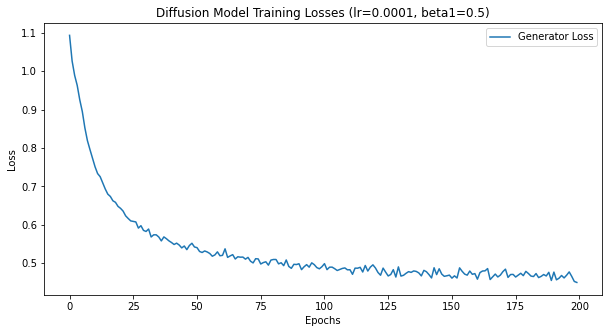

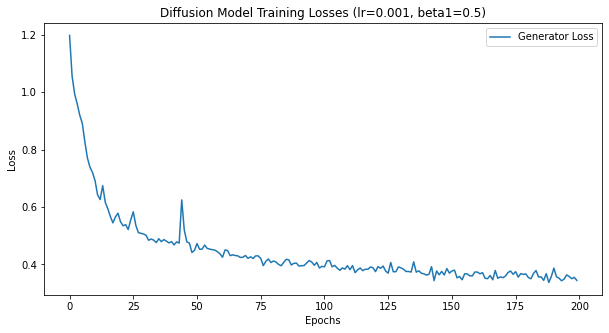

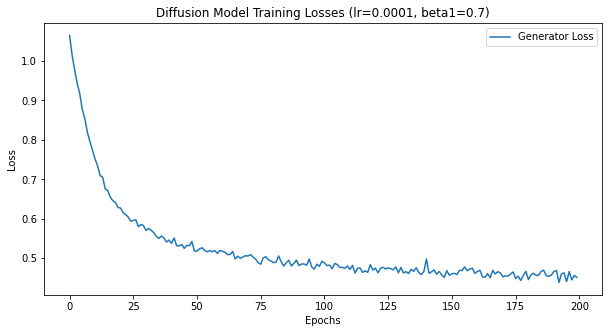

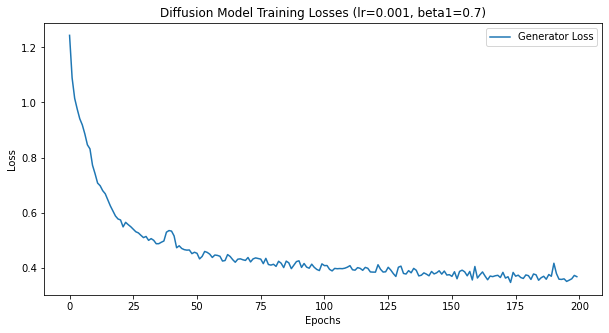

In [49]:
diffusion_losses, diffusion_filenames = load_losses('diffusion_losses')
plot_losses(diffusion_losses, diffusion_filenames, 'Diffusion Model')

# Training the Diffusion model with best hyperparameters

In [34]:
num_epochs = 250
best_model = UNet().apply(weights_init).to(device)
best_diffusion_model = DiffusionModel(best_model)
G_losses_diff, img_list, training_time_best_model = train_diffusion_model_with_time(dataloader, best_model, best_diffusion_model, num_epochs, best_model_params['lr'], best_model_params['beta1'])

Epoch [1/250] Batch [0/3] Loss: 1.082291841506958 MSE Loss: 0.3043631911277771 Perceptual Loss: 7.779286861419678
Epoch [2/250] Batch [0/3] Loss: 1.0617376565933228 MSE Loss: 0.31119710206985474 Perceptual Loss: 7.505405426025391
Epoch [3/250] Batch [0/3] Loss: 0.9789612293243408 MSE Loss: 0.2818361520767212 Perceptual Loss: 6.971250534057617
Epoch [4/250] Batch [0/3] Loss: 0.8905470967292786 MSE Loss: 0.24505960941314697 Perceptual Loss: 6.4548749923706055
Epoch [5/250] Batch [0/3] Loss: 0.8523281216621399 MSE Loss: 0.21934670209884644 Perceptual Loss: 6.3298139572143555
Epoch [6/250] Batch [0/3] Loss: 0.8022506237030029 MSE Loss: 0.1891370713710785 Perceptual Loss: 6.131135940551758
Epoch [7/250] Batch [0/3] Loss: 0.7546161413192749 MSE Loss: 0.1747020184993744 Perceptual Loss: 5.799140930175781
Epoch [8/250] Batch [0/3] Loss: 0.742256760597229 MSE Loss: 0.16148358583450317 Perceptual Loss: 5.807731628417969
Epoch [9/250] Batch [0/3] Loss: 0.6869184970855713 MSE Loss: 0.1425760090351

# Plot generator losses for Diffusion Model

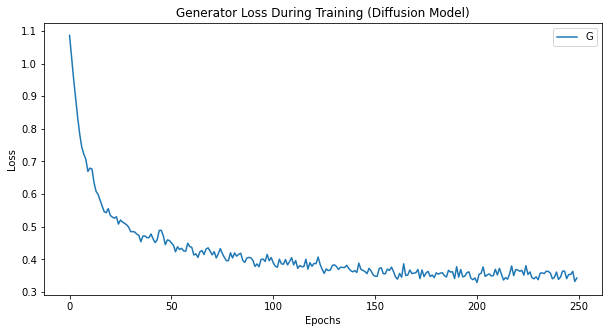

In [35]:
plt.figure(figsize=(10, 5))
plt.title("Generator Loss During Training (Diffusion Model)")
plt.plot(G_losses_diff, label="G")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Defining Generator for DC-GANS

In [16]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [17]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Defining Discriminator for DC-GANS

In [18]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [19]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Image Generator for DC-GANS

In [20]:
def generate_images_dcgan(generator, num_images, nz):
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    return generated_images

# DC-GANS Training Function

In [21]:
def train_dcgan_with_fid(dataloader, netG, netD, num_epochs, lr, beta1):
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    real_label = 1.
    fake_label = 0.
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Track time
    start_time = time.time()

    # Lists to keep track of progress
    img_list = []
    G_losses_epoch = []
    D_losses_epoch = []

    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        epoch_G_loss = 0
        epoch_D_loss = 0
        for i, data in enumerate(dataloader, 0):
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            epoch_G_loss += errG.item()
            epoch_D_loss += errD.item()

            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Store epoch losses
        G_losses_epoch.append(epoch_G_loss / len(dataloader))
        D_losses_epoch.append(epoch_D_loss / len(dataloader))

        if (epoch == num_epochs-1):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    end_time = time.time()
    training_time = end_time - start_time

    # Generate images and calculate FID and Inception scores
    real_images = next(iter(dataloader))[0].to(device)
    real_images_pil = [transforms.ToPILImage()(img.cpu()) for img in real_images]
    fake_images = generate_images_dcgan(netG, len(dataloader.dataset), nz)
    fake_images_pil = [transforms.ToPILImage()(img.cpu()) for img in fake_images]
    fid_score = calculate_fid(real_images_pil, fake_images_pil, inception_model)
    inception_score, inception_std = calculate_inception_score(fake_images_pil, inception_model)

    return G_losses_epoch, D_losses_epoch, img_list, training_time, fid_score, inception_score, inception_std


# Hyperparameter tuning for DCGAN


In [22]:
best_inception_score_dcgan = 0
best_fid_dcgan = float('inf')
best_dcgan_params = None
hyperparams_list_dcgan = [
    {'lr': 0.0001, 'beta1': 0.5},
    {'lr': 0.0001, 'beta1': 0.7},
    {'lr': 0.001, 'beta1': 0.5},
    {'lr': 0.001, 'beta1': 0.7},
]


# Hyperparameter tuning on DC-GANS and getting best parameters

In [29]:
num_epochs = 200
for idx, params in enumerate(hyperparams_list_dcgan):
    print(f"Training DCGAN with hyperparameters: {params}")

    netG = Generator(ngpu).apply(weights_init).to(device)
    netD = Discriminator(ngpu).apply(weights_init).to(device)

    G_losses_dcgan, D_losses_dcgan, img_list_dcgan, training_time_dcgan, fid_score_dcgan, inception_score_dcgan, inception_std_dcgan = train_dcgan_with_fid(
        dataloader, netG, netD, num_epochs, params['lr'], params['beta1']
    )

    print(f"FID score: {fid_score_dcgan}")
    print(f"Inception score: {inception_score_dcgan} ± {inception_std_dcgan}")

    # Save losses and model state
    with open(f'dc_gans_losses/losses_{params["lr"]}_{params["beta1"]}.pkl', 'wb') as f:
        pickle.dump({'G_losses': G_losses_dcgan, 'D_losses': D_losses_dcgan, 'FID': fid_score_dcgan, 'Inception Score': inception_score_dcgan, 'Inception Std': inception_std_dcgan}, f)
    torch.save(netG.state_dict(), f'dc_gans_models/netG_{params["lr"]}_{params["beta1"]}.pth')
    torch.save(netD.state_dict(), f'dc_gans_models/netD_{params["lr"]}_{params["beta1"]}.pth')

    if fid_score_dcgan < best_fid_dcgan:
        best_fid_dcgan = fid_score_dcgan
        best_dcgan_params = params
        torch.save(netG.state_dict(), "best_models/best_dcgan_generator.pth")
        torch.save(netD.state_dict(), "best_models/best_dcgan_discriminator.pth")

    if inception_score_dcgan > best_inception_score_dcgan:
        best_inception_score_dcgan = inception_score_dcgan

print(f"Best hyperparameters for DCGAN: {best_dcgan_params}")
print(f"Best Inception Score for DCGAN: {best_inception_score_dcgan}")
print(f"Best hyperparameters for DCGAN: {best_dcgan_params}")

Training DCGAN with hyperparameters: {'lr': 0.0001, 'beta1': 0.5}
Starting Training Loop...
[0/200][0/3]	Loss_D: 1.1415	Loss_G: 2.4389	D(x): 0.5808	D(G(z)): 0.3709 / 0.1284
[1/200][0/3]	Loss_D: 0.3013	Loss_G: 4.3605	D(x): 0.9847	D(G(z)): 0.2190 / 0.0209
[2/200][0/3]	Loss_D: 0.2047	Loss_G: 4.3972	D(x): 0.9701	D(G(z)): 0.1328 / 0.0225
[3/200][0/3]	Loss_D: 0.1271	Loss_G: 4.9078	D(x): 0.9791	D(G(z)): 0.0926 / 0.0122
[4/200][0/3]	Loss_D: 0.1254	Loss_G: 5.1032	D(x): 0.9692	D(G(z)): 0.0810 / 0.0102
[5/200][0/3]	Loss_D: 0.0681	Loss_G: 5.4973	D(x): 0.9869	D(G(z)): 0.0513 / 0.0064
[6/200][0/3]	Loss_D: 0.0769	Loss_G: 5.7016	D(x): 0.9845	D(G(z)): 0.0564 / 0.0052
[7/200][0/3]	Loss_D: 0.0669	Loss_G: 5.8448	D(x): 0.9845	D(G(z)): 0.0478 / 0.0041
[8/200][0/3]	Loss_D: 0.0522	Loss_G: 6.1655	D(x): 0.9864	D(G(z)): 0.0363 / 0.0033
[9/200][0/3]	Loss_D: 0.0458	Loss_G: 6.2281	D(x): 0.9881	D(G(z)): 0.0320 / 0.0028
[10/200][0/3]	Loss_D: 0.0330	Loss_G: 6.8563	D(x): 0.9884	D(G(z)): 0.0201 / 0.0017
[11/200][0/3]	Lo

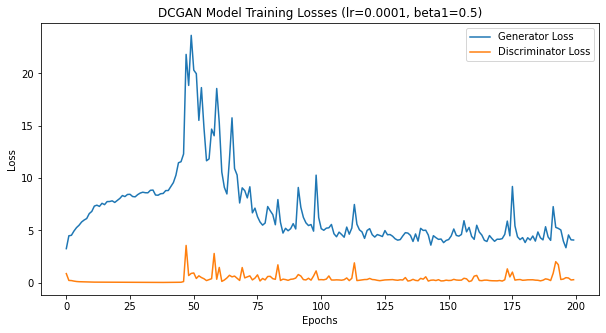

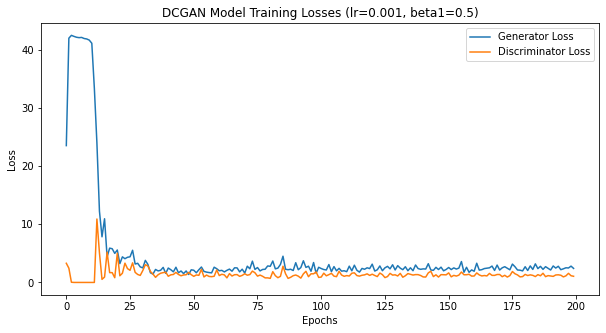

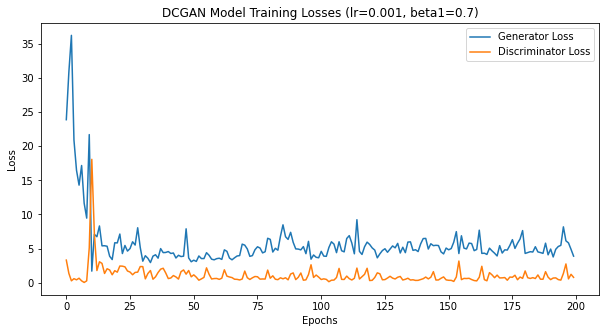

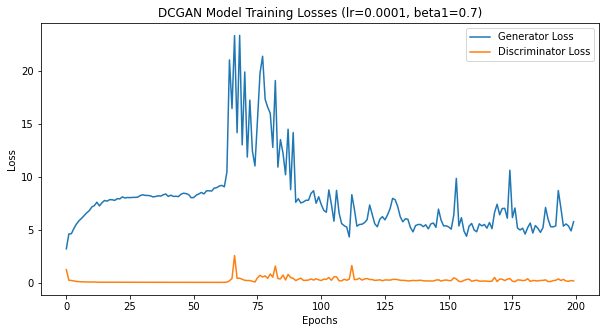

In [50]:
dcgan_losses, dcgan_filenames = load_losses('dc_gans_losses')
plot_losses(dcgan_losses, dcgan_filenames, 'DCGAN Model')

# Training the DCGAN model with best hyperparameters

In [37]:
num_epochs = 250
best_netG = Generator(ngpu).apply(weights_init).to(device)
best_netD = Discriminator(ngpu).apply(weights_init).to(device)

G_losses_best_dcgan, D_losses_best_dcgan, img_list_best_dcgan, training_time_best_dcgan, fid_score_best_dcgan, inception_score_best_dcgan, inception_std_best_dcgan = train_dcgan_with_fid(
    dataloader, best_netG, best_netD, num_epochs, best_dcgan_params['lr'], best_dcgan_params['beta1']
)

Starting Training Loop...
[0/250][0/3]	Loss_D: 1.2108	Loss_G: 13.6903	D(x): 0.5619	D(G(z)): 0.3614 / 0.0000
[1/250][0/3]	Loss_D: 7.5893	Loss_G: 32.0001	D(x): 0.9500	D(G(z)): 0.9985 / 0.0000
[2/250][0/3]	Loss_D: 0.0754	Loss_G: 36.8962	D(x): 0.9736	D(G(z)): 0.0000 / 0.0000
[3/250][0/3]	Loss_D: 0.0259	Loss_G: 31.4327	D(x): 0.9839	D(G(z)): 0.0000 / 0.0000
[4/250][0/3]	Loss_D: 0.1395	Loss_G: 26.7733	D(x): 0.9838	D(G(z)): 0.0366 / 0.0000
[5/250][0/3]	Loss_D: 1.7058	Loss_G: 15.4905	D(x): 0.5779	D(G(z)): 0.0247 / 0.0000
[6/250][0/3]	Loss_D: 0.5928	Loss_G: 22.8357	D(x): 0.8924	D(G(z)): 0.0000 / 0.0000
[7/250][0/3]	Loss_D: 2.6043	Loss_G: 13.2456	D(x): 0.9245	D(G(z)): 0.5624 / 0.0002
[8/250][0/3]	Loss_D: 0.5582	Loss_G: 7.2087	D(x): 0.9100	D(G(z)): 0.1420 / 0.0401
[9/250][0/3]	Loss_D: 0.7209	Loss_G: 6.8489	D(x): 0.8109	D(G(z)): 0.1501 / 0.0108
[10/250][0/3]	Loss_D: 0.6569	Loss_G: 3.9335	D(x): 0.8039	D(G(z)): 0.0827 / 0.1202
[11/250][0/3]	Loss_D: 0.6138	Loss_G: 6.2070	D(x): 0.9243	D(G(z)): 0.2590 /

# Plot generator and discriminator losses for DCGAN

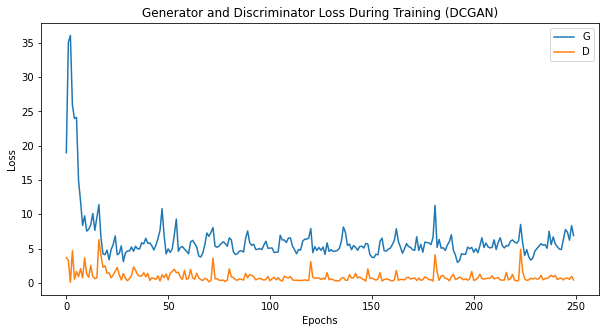

In [38]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training (DCGAN)")
plt.plot(G_losses_best_dcgan, label="G")
plt.plot(D_losses_best_dcgan, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Image Generation from Noise

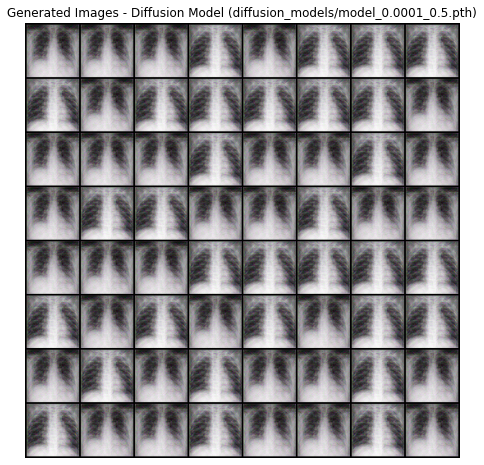

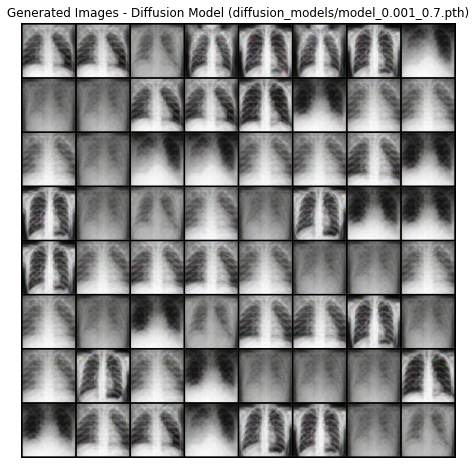

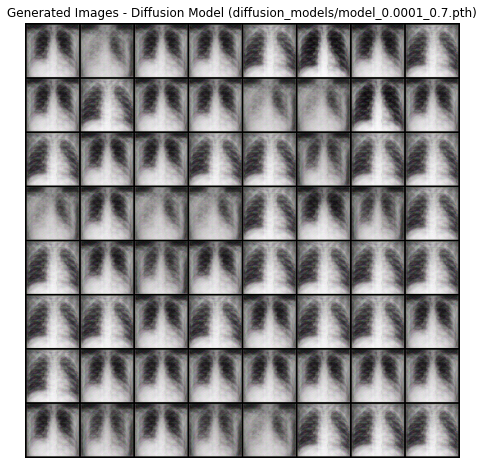

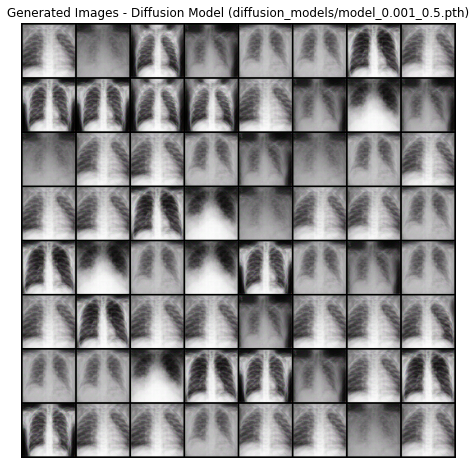

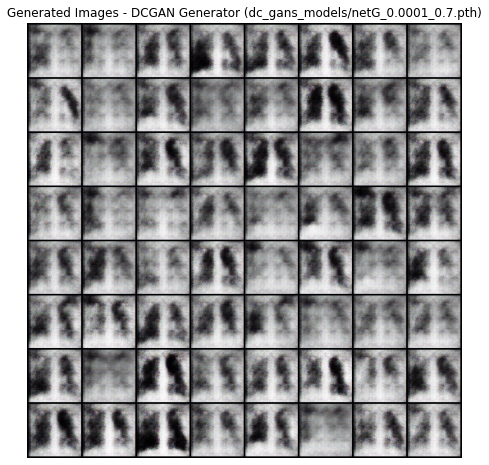

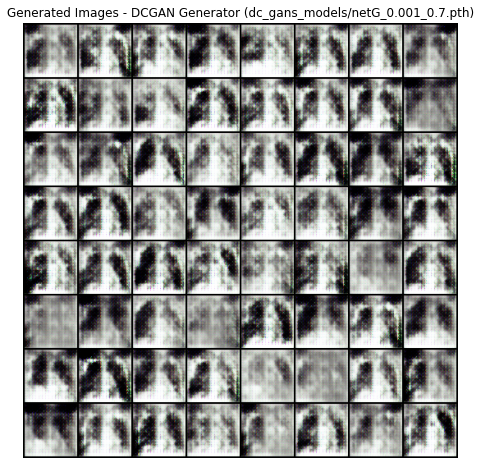

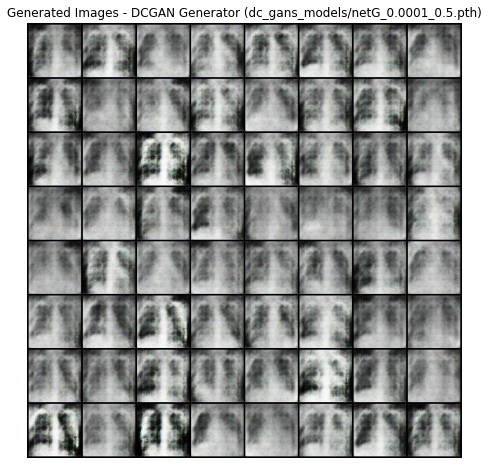

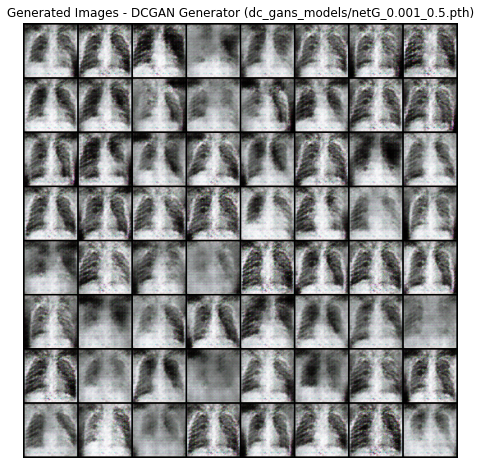

In [33]:
# Load the diffusion model and DCGAN model weights
def load_model_weights(model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

# Generate images using the models
def generate_diffusion_images(model, diffusion_model, num_images):
    noise = torch.randn(num_images, nc, image_size, image_size, device=device)
    with torch.no_grad():
        generated_images = diffusion_model.sample(noise)
    return generated_images

def generate_dcgan_images(generator, num_images, nz):
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    return generated_images

# Display generated images
def display_images(images, title):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images, padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

diffusion_model_paths = [os.path.join('diffusion_models', f) for f in os.listdir('diffusion_models') if f.endswith('.pth')]
dcgan_generator_paths = [os.path.join('dc_gans_models', f) for f in os.listdir('dc_gans_models') if 'netG' in f]

num_images = 64  # Number of images to generate
nz = 100  # Latent vector size for DCGAN

# Generate images using Diffusion Model
for model_path in diffusion_model_paths:
    model = UNet().to(device)
    diffusion_model = DiffusionModel(model)
    model = load_model_weights(model, model_path)
    generated_images = generate_diffusion_images(model, diffusion_model, num_images)
    display_images(generated_images, f'Generated Images - Diffusion Model ({model_path})')

# Generate images using DCGAN
for model_path in dcgan_generator_paths:
    generator = Generator(ngpu).to(device)
    generator = load_model_weights(generator, model_path)
    generated_images = generate_dcgan_images(generator, num_images, nz)
    display_images(generated_images, f'Generated Images - DCGAN Generator ({model_path})')

# Generate images from both models

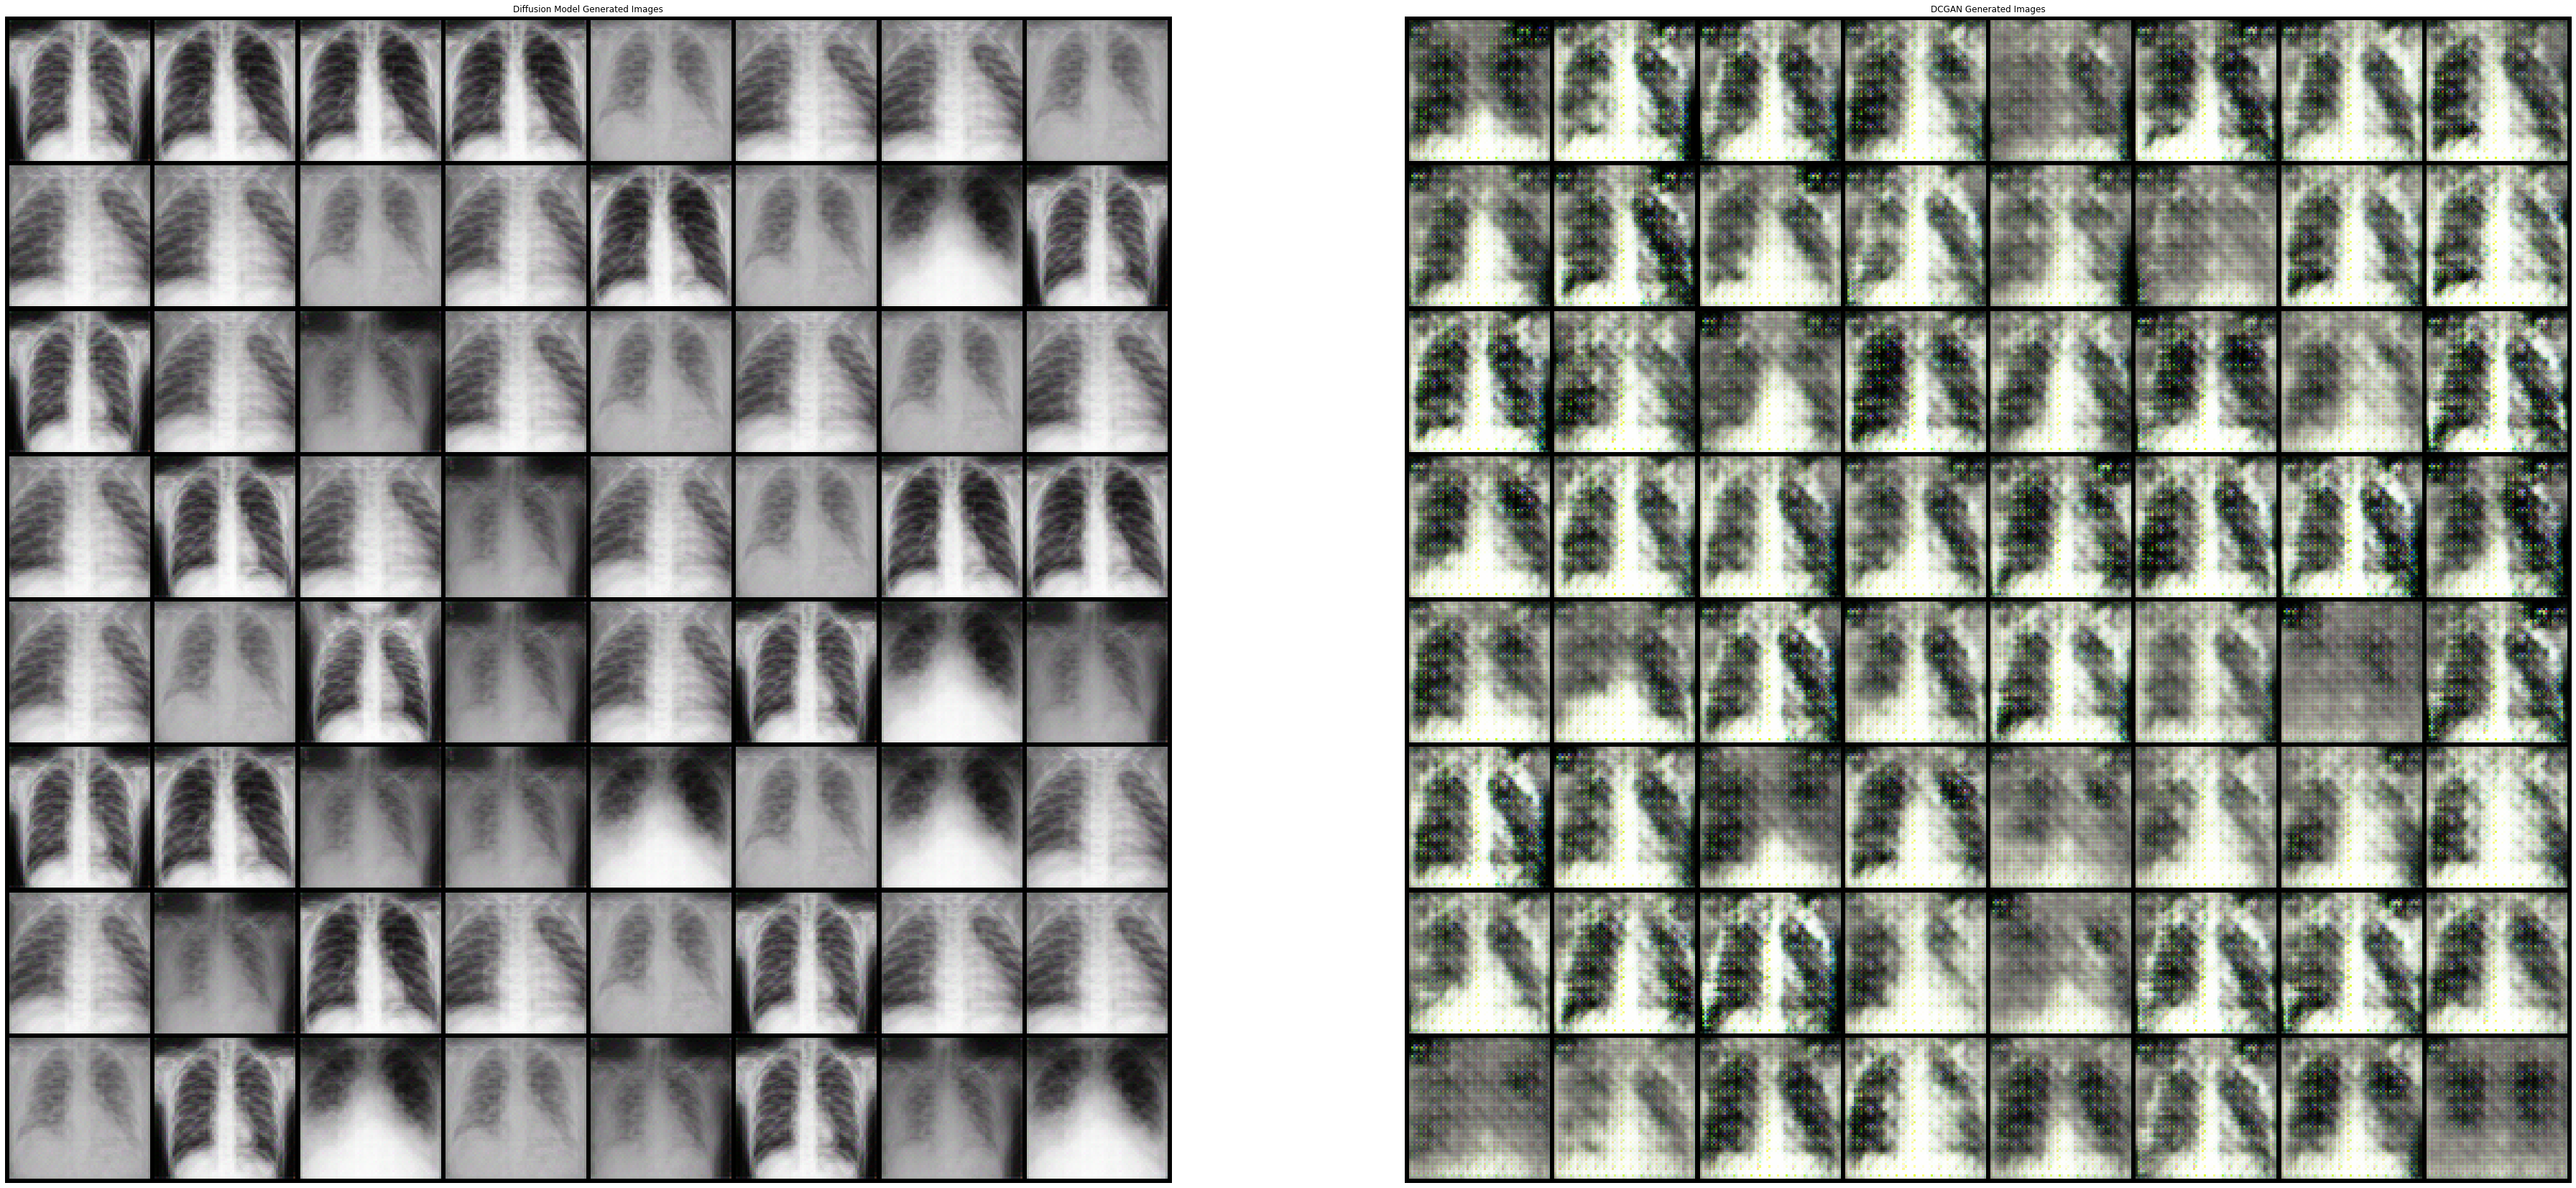

In [42]:
new_images_diff = generate_images(model, diffusion_model, 64)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    new_images_best_dcgan = best_netG(fixed_noise).detach().cpu()

plt.figure(figsize=(64,64))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Diffusion Model Generated Images")
plt.imshow(np.transpose(vutils.make_grid(new_images_diff, padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("DCGAN Generated Images")
plt.imshow(np.transpose(vutils.make_grid(new_images_best_dcgan, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

# Compare training times

In [40]:
print(f"Training Time for Diffusion Model: {training_time_diff} seconds")
print(f"Training Time for DCGAN: {training_time_best_dcgan} seconds")

Training Time for Diffusion Model: 955.839679479599 seconds
Training Time for DCGAN: 1280.6716103553772 seconds


# Calculate and compare FID scores

In [41]:
fid_score_diff = calculate_fid(real_images_pil, [transforms.ToPILImage()(img.cpu()) for img in new_images_diff], inception_model)
fid_score_best_dcgan = calculate_fid(real_images_pil, [transforms.ToPILImage()(img.cpu()) for img in new_images_best_dcgan], inception_model)

print(f"FID Score for Diffusion Model: {fid_score_diff}")
print(f"FID Score for Best DCGAN: {fid_score_best_dcgan}")

FID Score for Diffusion Model: 1199.3796504533175
FID Score for Best DCGAN: 1125.7944171347297


# Calculate and compare Inception scores

In [43]:
inception_score_diff, inception_std_diff = calculate_inception_score([transforms.ToPILImage()(img.cpu()) for img in new_images_diff], inception_model)
inception_score_best_dcgan, inception_std_best_dcgan = calculate_inception_score([transforms.ToPILImage()(img.cpu()) for img in new_images_best_dcgan], inception_model)

print(f"Inception Score for Diffusion Model: {inception_score_diff} ± {inception_std_diff}")
print(f"Inception Score for Best DCGAN: {inception_score_best_dcgan} ± {inception_std_best_dcgan}")

Inception Score for Diffusion Model: 1.6471960544586182 ± 0.05443725734949112
Inception Score for Best DCGAN: 1.831146240234375 ± 0.22770574688911438


# ==================== END OF FILE ====================